In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
import time
import ipywidgets as widgets


In [2]:

all_pokemon = []
url = "https://pokeapi.co/api/v2/pokemon?limit=100"

while url:
    response = requests.get(url)
    data = response.json()
    
    all_pokemon.extend(data['results'])
    
    url = data['next']

df = pd.DataFrame(all_pokemon)

print(f"Total Pokemon: {len(df)}")
print(df.head())

Total Pokemon: 1302
         name                                   url
0   bulbasaur  https://pokeapi.co/api/v2/pokemon/1/
1     ivysaur  https://pokeapi.co/api/v2/pokemon/2/
2    venusaur  https://pokeapi.co/api/v2/pokemon/3/
3  charmander  https://pokeapi.co/api/v2/pokemon/4/
4  charmeleon  https://pokeapi.co/api/v2/pokemon/5/


In [3]:
detailed_data = []

for idx, poke in enumerate(all_pokemon):
    res = requests.get(poke['url'])
    info = res.json()
    types = [t['type']['name'] for t in info['types']]
    detailed_data.append({
        'id': info['id'],
        'name': info['name'],
        'height': info['height'],
        'weight': info['weight'],
        'base_experience': info['base_experience'],
        'types': [t['type']['name'] for t in info['types']],
        'abilities': [a['ability']['name'] for a in info['abilities']],
        'hp': next(s['base_stat'] for s in info['stats'] if s['stat']['name'] == 'hp'),
        'attack': next(s['base_stat'] for s in info['stats'] if s['stat']['name'] == 'attack'),
        'defense': next(s['base_stat'] for s in info['stats'] if s['stat']['name'] == 'defense'),
        'speed': next(s['base_stat'] for s in info['stats'] if s['stat']['name'] == 'speed'),
        'image_url': f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{info['id']}.png", 
    })
    
    if (idx+1) % 100 == 0:
        print(f"Fetched {idx+1} Pokémon...")  
        time.sleep(1)  


Fetched 100 Pokémon...
Fetched 200 Pokémon...
Fetched 300 Pokémon...
Fetched 400 Pokémon...
Fetched 500 Pokémon...
Fetched 600 Pokémon...
Fetched 700 Pokémon...
Fetched 800 Pokémon...
Fetched 900 Pokémon...
Fetched 1000 Pokémon...
Fetched 1100 Pokémon...
Fetched 1200 Pokémon...
Fetched 1300 Pokémon...


In [4]:

df = pd.DataFrame(detailed_data)

df_explode = df.explode('types')

   
df.to_csv('all_pokemon_data.csv', index=False)
df = pd.read_csv('all_pokemon_data.csv')


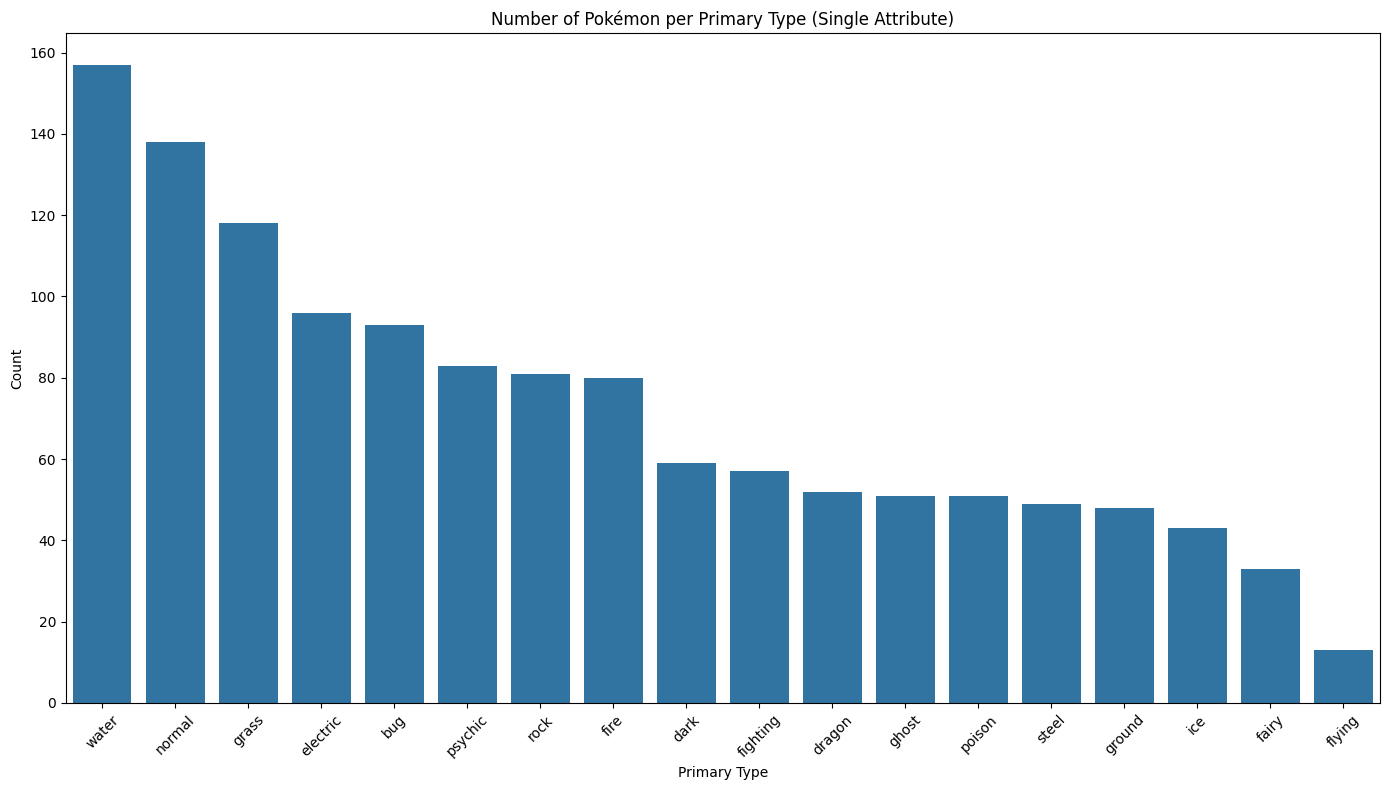

In [5]:


import ast

df['types'] = df['types'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['primary_type'] = df['types'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)


plt.figure(figsize=(14,8))
sns.countplot(data=df, x='primary_type', order=df['primary_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of Pokémon per Primary Type (Single Attribute)')
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 📊 Number of Pokémon per Primary Type

This bar chart shows the number of Pokémon that belong to each **primary type**.

- Only the **first type** of each Pokémon is counted.
- Water, Normal, and Grass types are the most common.
- Flying-type Pokémon are the least represented as a primary type.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap

output_notebook()

source = ColumnDataSource(df)

types_list = df['primary_type'].dropna().unique().tolist()

p = figure(
    title="Attack vs Defense of Pokémon (Colored by Primary Type)",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    width=900,
    height=600
)

p.scatter(
    'attack', 
    'defense', 
    source=source,
    size=8,
    color=factor_cmap('primary_type', palette="Category20_20", factors=types_list),
    alpha=0.7
)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Name", "@name"),
    ("Primary Type", "@primary_type"),
    ("Attack", "@attack"),
    ("Defense", "@defense"),
    ("HP", "@hp"),
    ("Speed", "@speed")
]

show(p)

Loading BokehJS ...

### ⚔️ Attack vs Defense Scatter Plot (Colored by Type)

This scatter plot visualizes the relationship between **Attack** and **Defense** stats across all Pokémon.

- Each dot represents one Pokémon.
- Points are color-coded by their **primary type**.
- You can observe how different types are distributed in terms of offensive and defensive strength.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

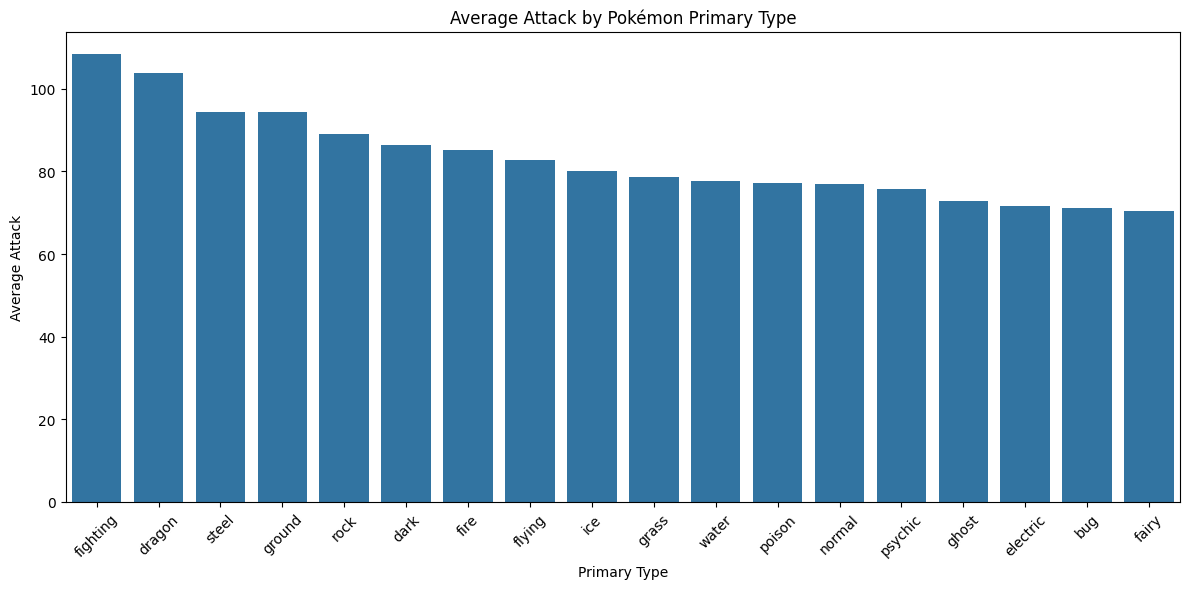

In [7]:
attack_means = df.groupby('primary_type')['attack'].mean().sort_values(ascending=False)
defense_means = df.groupby('primary_type')['defense'].mean().sort_values(ascending=False)


plt.figure(figsize=(12,6))
sns.barplot(x=attack_means.index, y=attack_means.values)
plt.title('Average Attack by Pokémon Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Average Attack')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 💥 Average Attack by Pokémon Primary Type

This bar chart shows the average **Attack** stat for each primary Pokémon type.

- Types are sorted by descending attack power.
- Fighting and Dragon types are among the **most powerful**, while Fairy and Bug types have lower average attack.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

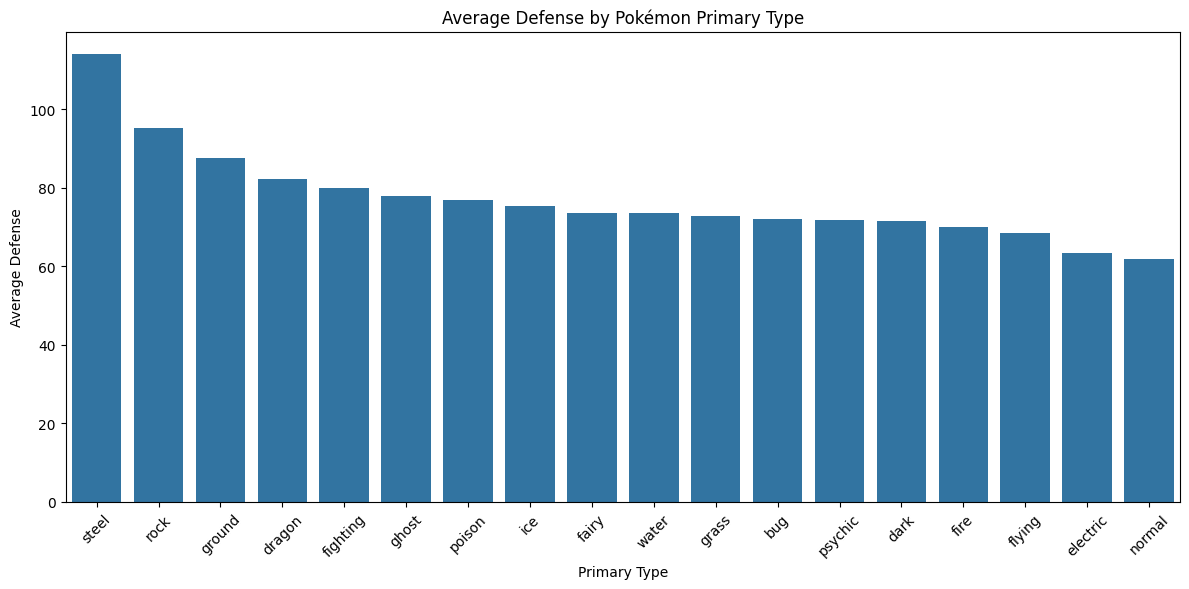

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(x=defense_means.index, y=defense_means.values)
plt.title('Average Defense by Pokémon Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Average Defense')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🛡️ Average Defense by Pokémon Primary Type

This bar chart shows the average **Defense** stat for each primary Pokémon type.

- Types are sorted from highest to lowest average defense.
- Steel-type Pokémon tend to be the **toughest**, while Normal-types have the lowest average defense.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

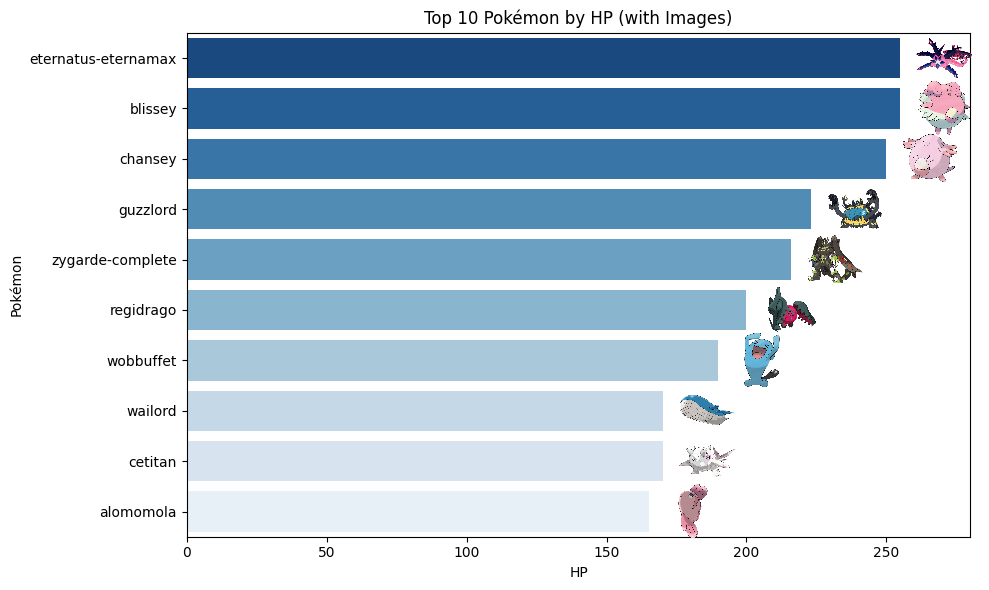

In [9]:

from io import BytesIO
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox




top_hp = df.sort_values('hp', ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    y=top_hp['name'], 
    x=top_hp['hp'], 
    hue=top_hp['name'],          
    palette='Blues_r', 
    dodge=False, 
    legend=False
)
for i, (y, img_url) in enumerate(zip(top_hp['name'], top_hp['image_url'])):
    try:
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content))

        imagebox = OffsetImage(img, zoom=0.09)
        ab = AnnotationBbox(imagebox, (top_hp['hp'][i] + 5, i), frameon=False, box_alignment=(0, 0.5))
        plt.gca().add_artist(ab)
    except:
        print(f" Failed to load image for {y}")

plt.title("Top 10 Pokémon by HP (with Images)")
plt.xlabel("HP")
plt.xlim(0, 280)
plt.ylabel("Pokémon")
plt.tight_layout()
plt.show()

### ⚡ Top 10 Tankiest Pokémon

This horizontal bar chart displays the top 10 Pokémon ranked by base **HP**.

- Each bar represents a Pokémon’s Health stat.
- Pokémon images are shown to the right of their corresponding bars for easier recognition.
- Color gradient highlights relative ranking, with darker bars representing tankiest Pokémon.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
def plot_top10_stat(df, stat='attack', color='Reds_r', title='Top 10 Pokémon by Attack', xmax=300):
   

    top_df = df.sort_values(stat, ascending=False).head(10).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        y=top_df['name'], 
        x=top_df[stat], 
        hue=top_df['name'],          
        palette=color, 
        dodge=False, 
        legend=False
    )

    for i, (y, img_url) in enumerate(zip(top_df['name'], top_df['image_url'])):
        try:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            imagebox = OffsetImage(img, zoom=0.09)
            ab = AnnotationBbox(imagebox, (top_df[stat][i] + 5, i), frameon=False, box_alignment=(0, 0.5))
            plt.gca().add_artist(ab)
        except:
            print(f"⚠️ Failed to load image for {y}")

    plt.title(title)
    plt.xlabel(stat.capitalize())
    plt.xlim(0, xmax)  
    plt.ylabel("Pokémon")
    plt.tight_layout()
    plt.show()

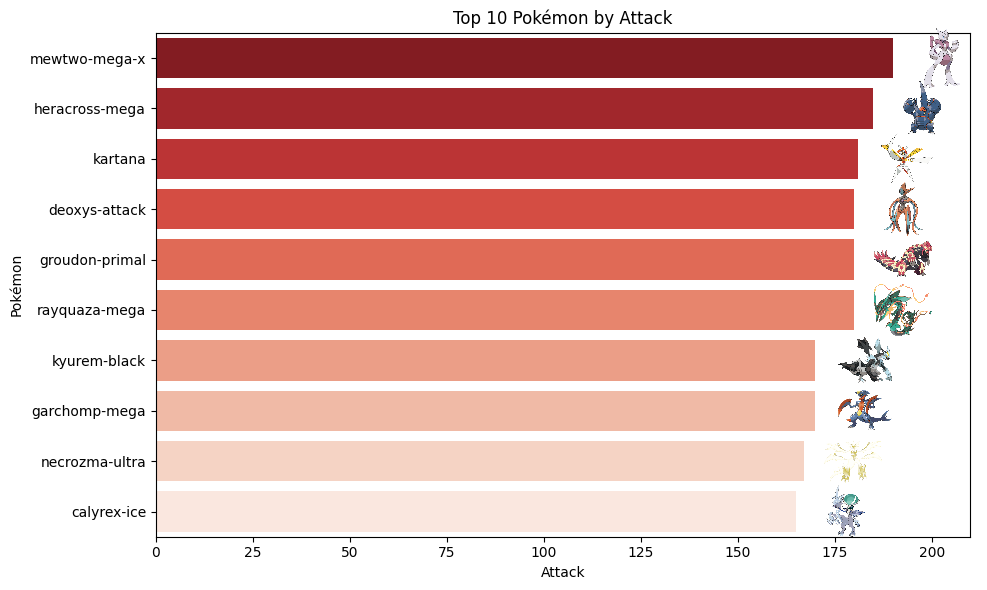

In [11]:
plot_top10_stat(df, stat='attack', color='Reds_r', title='Top 10 Pokémon by Attack', xmax=210)



### ⚡ Top 10 Strongest Pokémon

This horizontal bar chart displays the top 10 Pokémon ranked by base **Attack**.

- Each bar represents a Pokémon’s attack stat.
- Pokémon images are shown to the right of their corresponding bars for easier recognition.
- Color gradient highlights relative ranking, with darker bars representing strongest Pokémon.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

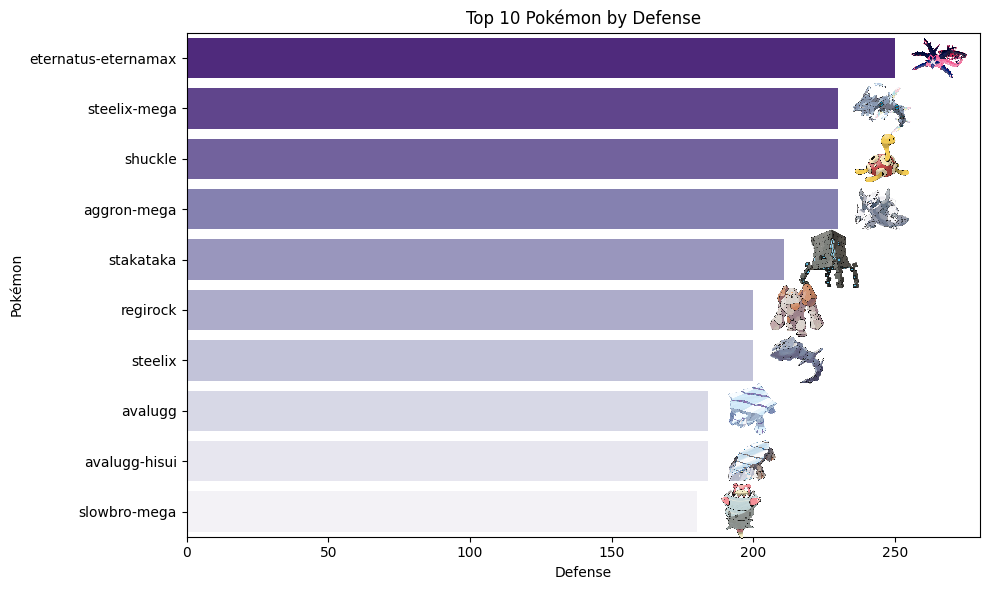

In [12]:
plot_top10_stat(df, stat='defense', color='Purples_r', title='Top 10 Pokémon by Defense', xmax=280)



### ⚡ Top 10 Toughest Pokémon

This horizontal bar chart displays the top 10 Pokémon ranked by base **Defense**.

- Each bar represents a Pokémon’s defense stat.
- Pokémon images are shown to the right of their corresponding bars for easier recognition.
- Color gradient highlights relative ranking, with darker bars representing Pokémon with highest defense.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

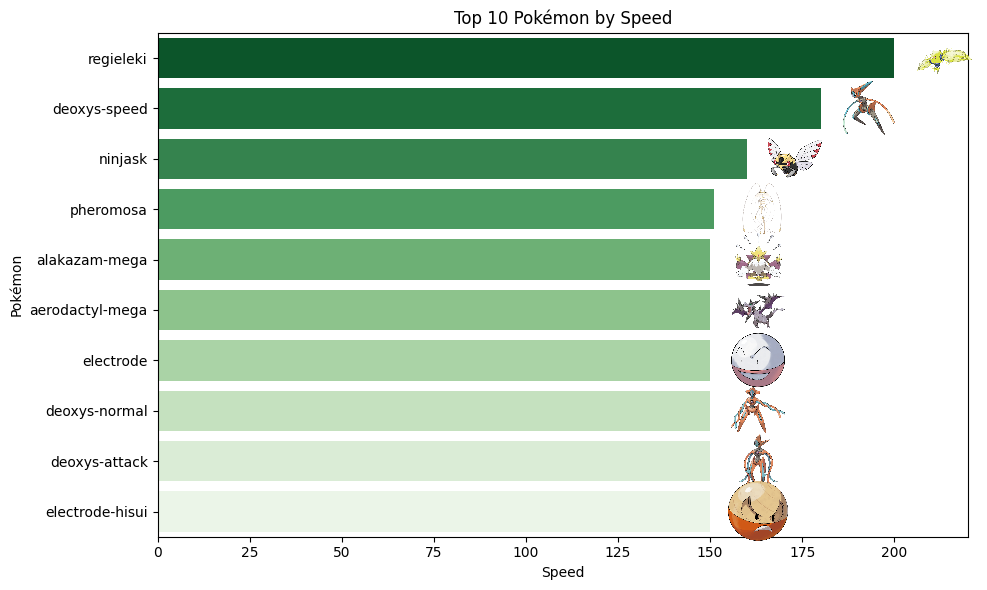

In [13]:
plot_top10_stat(df, stat='speed', color='Greens_r', title='Top 10 Pokémon by Speed', xmax=220)

### ⚡ Top 10 Fastest Pokémon

This horizontal bar chart displays the top 10 Pokémon ranked by base **Speed**.

- Each bar represents a Pokémon’s speed stat.
- Pokémon images are shown to the right of their corresponding bars for easier recognition.
- Color gradient highlights relative ranking, with darker bars representing faster Pokémon.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [43]:
from PIL import Image as PILImage
from io import BytesIO
from IPython.display import display, Image, Markdown

df = pd.read_csv("all_pokemon_data.csv")
df['types'] = df['types'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['primary_type'] = df['types'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

name_input = widgets.Text(description='Name:', placeholder='e.g. pikachu')
type_dropdown = widgets.Dropdown(options=['All'] + sorted(df['primary_type'].dropna().unique()), description='Type:')
pokemon_dropdown = widgets.Dropdown(options=[], description='Pokémon:')
output_box = widgets.Output()

def get_evolution_chain(pokemon_name):
    try:
        res = requests.get(f"https://pokeapi.co/api/v2/pokemon-species/{pokemon_name.lower()}")
        evo_url = res.json()['evolution_chain']['url']
        evo_chain_data = requests.get(evo_url).json()['chain']

        chain = []
        def walk_chain(node):
            chain.append(node['species']['name'])
            for next_node in node['evolves_to']:
                walk_chain(next_node)
        walk_chain(evo_chain_data)
        return chain
    except:
        return []

def display_pokemon(name_query, type_filter, dropdown_name):
    output_box.clear_output()
    with output_box:
        filtered = df.copy()
        if type_filter != 'All':
            filtered = filtered[filtered['primary_type'] == type_filter]

        if name_query:
            filtered = filtered[filtered['name'].str.contains(name_query.lower(), case=False)]
        elif dropdown_name:  
            filtered = filtered[filtered['name'] == dropdown_name]

        if filtered.empty:
            display(Markdown("**No Pokémon found.**"))
            return

        pkm = filtered.iloc[0]
        display(Markdown(f"### {pkm['name'].capitalize()}"))

        try:
            img_data = requests.get(pkm['image_url']).content
            display(Image(data=img_data, width=150))
        except:
            display(Markdown("*(Image failed to load)*"))

        display(Markdown(f"**Type:** {', '.join(pkm['types'])}  "))
        display(Markdown(f"**HP:** {pkm['hp']}  "))
        display(Markdown(f"**Attack:** {pkm['attack']}  "))
        display(Markdown(f"**Defense:** {pkm['defense']}  "))
        display(Markdown(f"**Speed:** {pkm['speed']}  "))

        chain = get_evolution_chain(pkm['name'])
        if chain:
            slider = widgets.IntSlider(min=0, max=len(chain)-1, step=1, description='Stage')
            evo_output = widgets.Output()

            def update_stage(stage_index):
                evo_output.clear_output()
                evo_name = chain[stage_index]
                try:
                    evo_id = df[df['name'] == evo_name]['id'].values[0]
                    evo_img_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{evo_id}.png"
                    evo_img_data = requests.get(evo_img_url).content
                except:
                    evo_img_data = None

                with evo_output:
                    display(Markdown(f"### Evolution: {evo_name.capitalize()}"))
                    if evo_img_data:
                        display(Image(data=evo_img_data, width=150))
                    else:
                        display(Markdown("_Image failed to load._"))

                    evo_row = df[df['name'] == evo_name]
                    if not evo_row.empty:
                        evo_stats = evo_row.iloc[0]
                        display(Markdown(f"**Type:** {', '.join(evo_stats['types'])}  "))
                        display(Markdown(f"**HP:** {evo_stats['hp']}  "))
                        display(Markdown(f"**Attack:** {evo_stats['attack']}  "))
                        display(Markdown(f"**Defense:** {evo_stats['defense']}  "))
                        display(Markdown(f"**Speed:** {evo_stats['speed']}  "))

            slider.observe(lambda change: update_stage(change['new']), names='value')
            display(slider, evo_output)
            update_stage(0)

def update_pokemon_dropdown(*args):
    selected_type = type_dropdown.value
    if selected_type == 'All':
        pokemon_dropdown.options = []
    else:
        filtered_names = df[df['primary_type'] == selected_type]['name'].sort_values().tolist()
        pokemon_dropdown.options = filtered_names

def update_output(*args):
    display_pokemon(name_input.value, type_dropdown.value, pokemon_dropdown.value)

type_dropdown.observe(update_pokemon_dropdown, names='value')
name_input.observe(update_output, names='value')
type_dropdown.observe(update_output, names='value')
pokemon_dropdown.observe(update_output, names='value')

display(name_input, type_dropdown, pokemon_dropdown)
update_pokemon_dropdown()
display_pokemon(name_input.value, type_dropdown.value, pokemon_dropdown.value)
display(output_box)

Text(value='', description='Name:', placeholder='e.g. pikachu')

Dropdown(description='Type:', options=('All', 'bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire'…

Dropdown(description='Pokémon:', options=(), value=None)

Output()

# 🧬 Interactive Pokémon Viewer

This interactive tool allows you to explore detailed stats and evolution information for Pokémon using the [PokéAPI](https://pokeapi.co/).

## 🔎 How to Use

You can search Pokémon in **two ways** — by **name** or by **primary type**:

### 1. Search by Name
- Enter part or full Pokémon name in the **Name** box (e.g., `pikachu`, `char`).
- **Note**: When using name search, the **Type** must remain `All`, and the Pokémon dropdown will be ignored.

### 2. Filter by Type
- Select a primary type (e.g., `fire`, `grass`) from the **Type** dropdown.
- A second dropdown will appear, listing all Pokémon of that type.
- Select a Pokémon to view its stats.
- **Important**: If using type-based filtering, make sure the **Name box is empty**, otherwise it will override the type selection.

## 📋 What You'll See
- **Basic Info**: Name, official artwork, types, and stats (HP, Attack, Defense, Speed).
- **Evolution**: Slider to view evolutionary stages. Each stage includes:
  - Artwork
  - Name
  - Stats & type for that stage

## 🧠 Notes
- If a Pokémon has no evolution data or image, a fallback message will be shown.
- You can quickly test by searching `eevee`, `bulbasaur`, or selecting type `fire`.

Enjoy exploring the Pokémon universe!

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [42]:
from ipywidgets import (Text, Dropdown, SelectMultiple, Output, VBox, HBox, Image as WImage, Label, Layout)

df = pd.read_csv("all_pokemon_data.csv")
df['types'] = df['types'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['primary_type'] = df['types'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

compare_name_input = Text(description='Name:', placeholder='e.g. char')
compare_type_dropdown = Dropdown(options=['All'] + sorted(df['primary_type'].dropna().unique()), description='Type:')
compare_pokemon_dropdown = SelectMultiple(description='Pokémon:', options=[], rows=8)
compare_output = Output()

def update_compare_dropdown(*args):
    filtered = df.copy()
    name_val = compare_name_input.value.strip()
    type_val = compare_type_dropdown.value

    if name_val:
        filtered = filtered[filtered['name'].str.contains(name_val.lower(), case=False)]
    elif type_val != 'All':
        filtered = filtered[filtered['primary_type'] == type_val]

    compare_pokemon_dropdown.options = sorted(filtered['name'].tolist())

def plot_radar_compare(names):
    compare_output.clear_output()
    with compare_output:
        if not names:
            display(Markdown("**Please select at least one Pokémon.**"))
            return

        stats = ['hp', 'attack', 'defense', 'speed', 'base_experience']
        angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False).tolist()

        edge_colors = {
            'hp': 'deeppink',
            'attack': 'darkred',
            'defense': 'orange',
            'speed': 'green',
            'base_experience': 'blue'
        }

        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

        name = names[0]
        row = df[df['name'] == name]
        if row.empty:
            display(Markdown(f"⚠ Pokémon not found: {name}"))
            return

        values = row[stats].values.flatten().tolist()
        values += values[:1]
        angles_full = angles + [angles[0]]

        for i in range(len(stats)):
            angle_slice = [angles[i], angles[i+1] if i+1 < len(angles) else angles[0], angles[0]]
            value_slice = [values[i], values[i+1] if i+1 < len(values) else values[0], 0]

            ax.fill(
                angle_slice,
                value_slice,
                color=edge_colors[stats[i]],
                alpha=0.45,
                zorder=1
            )

        for i in range(len(stats)):
            ax.plot(
                angles_full[i:i+2],
                values[i:i+2],
                color=edge_colors[stats[i]],
                linewidth=2,
                zorder=2
            )

        for i, val in enumerate(values[:-1]):
            ax.text(
                angles[i],
                val + 6,
                str(val),
                ha='center',
                va='center',
                fontsize=11,
                fontweight='bold',
                color=edge_colors[stats[i]],
                zorder=3
            )

        ax.set_xticks(angles)
        ax.set_xticklabels([s.capitalize() for s in stats])
        ax.set_yticklabels([])
        ax.set_title("Radar Chart: Stat Comparison", size=14)

        buf = BytesIO()
        plt.tight_layout()
        plt.savefig(buf, format='png')
        buf.seek(0)
        radar_image = WImage(value=buf.read(), format='png', layout=Layout(width='400px'))
        buf.close()
        plt.close()

        image_boxes = []
        for name in names:
            row = df[df['name'] == name]
            if not row.empty:
                img_url = row['image_url'].values[0]
                try:
                    img_data = requests.get(img_url).content
                    poke_img = WImage(value=img_data, format='png', layout=Layout(width='300px'))
                    label = Label(name.capitalize())
                    image_boxes.append(
                        VBox([poke_img, label], layout=Layout(align_items='center'))
                    )
                except:
                    image_boxes.append(Label(f"{name} (image failed)"))

        layout = HBox([radar_image, VBox(image_boxes)], layout=Layout(align_items='center'))
        display(layout)

compare_name_input.observe(update_compare_dropdown, names='value')
compare_type_dropdown.observe(update_compare_dropdown, names='value')
compare_pokemon_dropdown.observe(lambda change: plot_radar_compare(compare_pokemon_dropdown.value), names='value')

update_compare_dropdown()
display(Markdown("###  Compare Pokémon Stats via Radar Chart"))
display(compare_name_input, compare_type_dropdown, compare_pokemon_dropdown)
display(compare_output)


###  Compare Pokémon Stats via Radar Chart

Text(value='', description='Name:', placeholder='e.g. char')

Dropdown(description='Type:', options=('All', 'bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire'…

SelectMultiple(description='Pokémon:', options=('abomasnow', 'abomasnow-mega', 'abra', 'absol', 'absol-mega', …

Output()

### 🧭 Pokémon Radar Chart Viewer

This interactive tool allows you to explore and compare the base stats of Pokémon using a radar chart visualization.

#### 🔍 Search and Filter Logic:
- **Name search**: Type part of a Pokémon’s name (e.g., `char`, `eevee`) to search.  
  ⛔ When using name search, the **Type** dropdown must be set to **All**.
- **Type filter**: Select a primary type (e.g., Fire, Water) to filter Pokémon by type.  
  ⛔ When using type filter, the **Name** box should be **left empty**.
- **Pokémon select**: Choose one or more Pokémon from the filtered results to display.

#### 📊 Radar Chart Features:
- The radar chart displays the following 5 base attributes:
  - **HP** (💓 Deep Pink)
  - **Attack** (🟥 dark red)
  - **Defense** (🟠 dark orange)
  - **Speed** (🟢 green)
  - **Base Experience** (🔵 blue)
- Each sector of the radar chart is **color-coded** according to the stat it represents.
- **Value labels** are shown at each vertex for clear comparison.
- The **maximum scale** of each stat is **auto-adjusted** to fit the highest value of the selected Pokémon — it is **not fixed**, ensuring a focused comparison.

#### 🖼️ Side Panel:
- Pokémon images and names are displayed alongside the radar chart.
- You can select multiple Pokémon to view their stats and images one at a time.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━